# Подготовка окружения и конфигурации

In [9]:
import torch

from utils import train, check_inference, eda

In [10]:
class Config:
    # заморозим рандомайзер
    SEED = 42

    # базовые модели
    IMAGE_MODEL_NAME = "tf_efficientnet_b0"

    # заморозка слоев наследуемых моделей
    IMAGE_MODEL_UNFREEZE = ""

    NUM_INGR = "" # посчитаем при инициализации обучающего датасета
    EMB_INGR = 32

    MASS_MEAN = ""  # посчитаем при инициализации обучающего датасета
    MASS_STD = ""  # посчитаем при инициализации обучающего датасета
    
    # гиперпараметры
    BATCH_SIZE = 64
    EMB_INGR_LR = 1e-3
    CLASSIFIER_LR = 1e-3
    EPOCHS = 45
    DROPOUT = 0.3
    HUBER_DELTA=30.0
    WEIGHT_DECAY=5e-4

    # файлы
    DF_PATH = "data/dish.csv"
    IMG_PATH = "data/images/"
    SAVE_PATH = "best_model.pth"

cfg = Config()
device = "cuda" if torch.cuda.is_available() else "cpu"
print('device: ', device)

device:  cuda


# Изучение объектов данных тестового сета

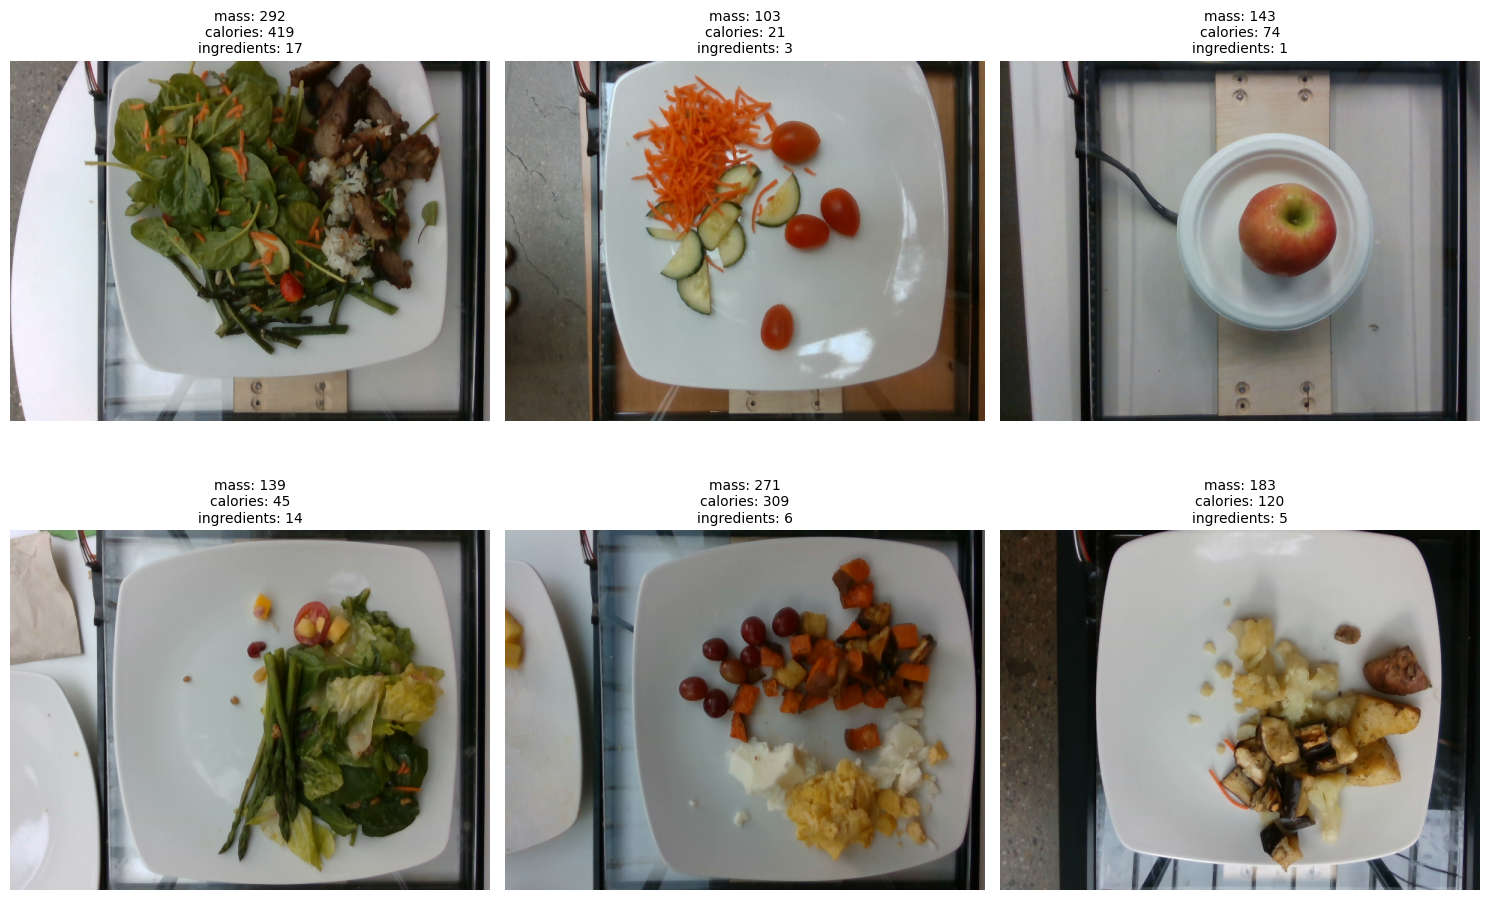

unique ingredients in train: 198
mean ingredients in dish: 7.4


In [11]:
eda(cfg)

## Выводы

1. Преимущественно белый фон фотографий. Блюда разложены не строго по центру, есть повороты как тарелок, так и блюд, есть смещения за край кадра
2. Картинки весьма пестрые особенно при наличии большого количества ингредиентов блюда
3. Большой разброс количества ингредиентов даже на малой выборке от 1 до 17
4. Больше количество уникальных ингредиентов в целом по сету и небольшое в среднем на блюдо

## Идеи на разработку

**картинка**
1. Возьмем сверточную модель без головы, попробуем обойтись без ее тюнинга
2. Добавим в обучающий датасет агументаций на флипы, повороты, оттенки цветов и контрастность

**ингредиенты**
1. Попробуем обойтись без отражения состава в язык и привлечения языковых моделей
2. Токенизируем коды ингрединтов в натуральные индексы, добавим паддинг на те коды, что не встретились в трейне
3. Натрениуем эмбеддинг в размерность 32 для добавления вектора ингредиентов в модель

**масса**
1. Каллорийность блюда (одного и того же в смысле состава и фото) растет пропорционально его массе, поэтому не будем делать со скаляром массы никаких преобразований, кроме нормализации на статистику тренировочного датасета

**мультимодальность**
1. Конкатенируем вектор картиники, суммовой ембеддинг ингредиентов и скаляр норнмализованной массы

**регрессор**
1. Сделаем три слоя со снижением размерности ->256->64->1
2. Активация RELU, добавим Dropout-ы для контроля переобучения

**итого**
1. Тренируем эмбеддинг ингредиентов и голову-регрессор
2. Используем pretrained-модель для векторизации картинок
2. Используем Huber-loss, как вариацию MAE

# Аугментация изображений

### Посмотрим на аугментированные предложенным подходом изображения блюд

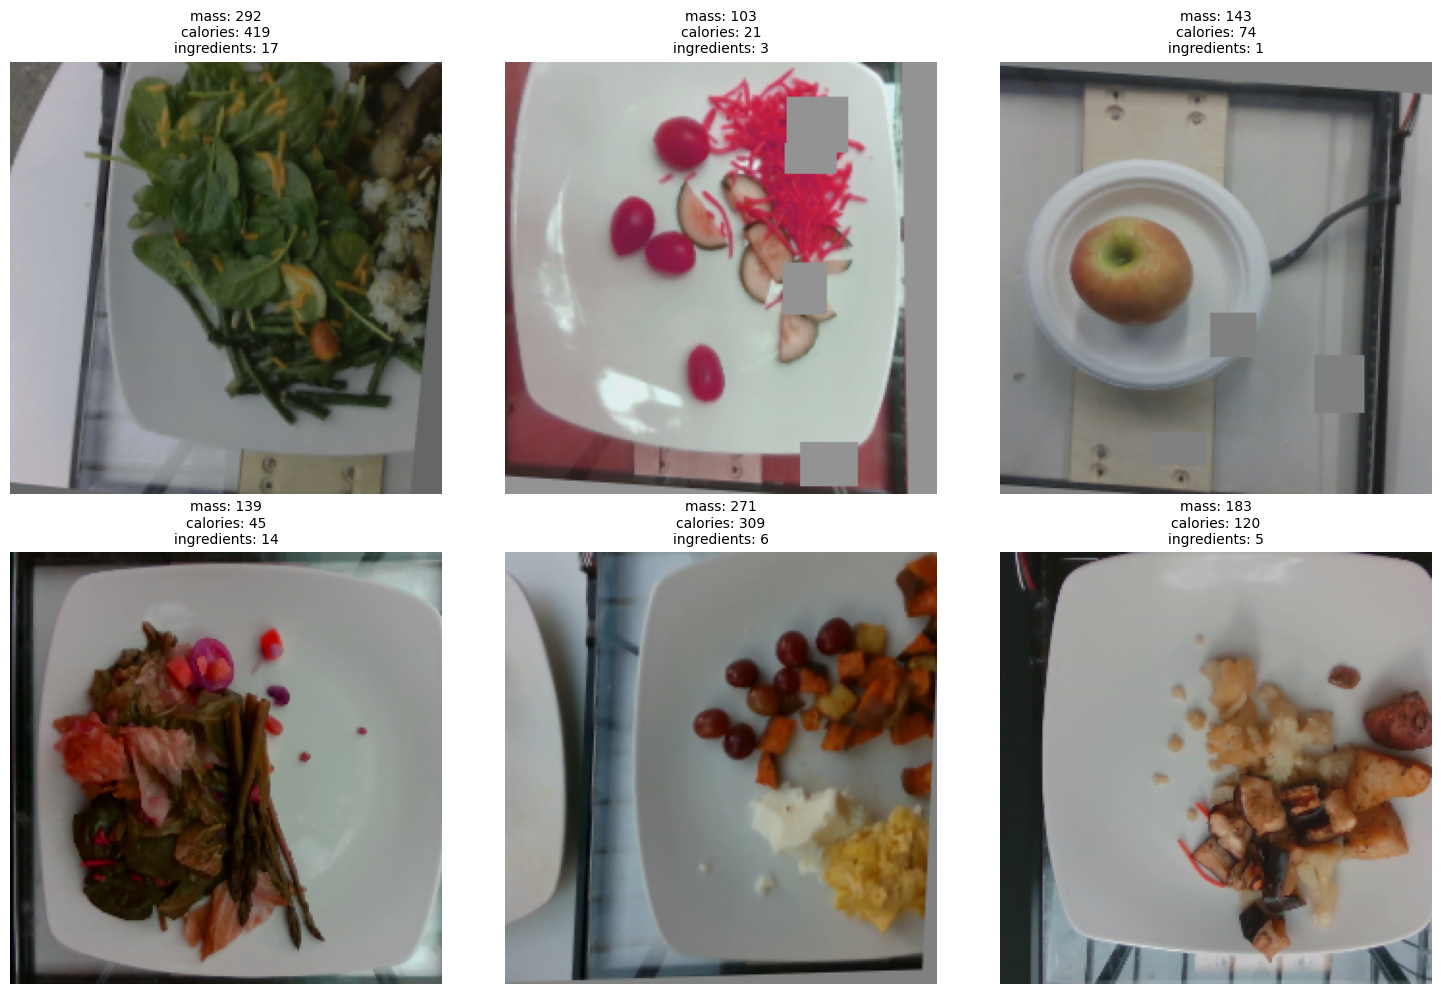

In [12]:
eda(cfg, augmented=True)

# Обучение модели

params to train: 359,265


  val epoch 1  : 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, last batch loss=4076.2, last batch mae=150.3]


total epoch 1   train loss 6410.3, val loss 5356.1 train mae 227.9, val mae 192.9
----------------------------------------
New best model, epoch: 1
----------------------------------------


  val epoch 2  : 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, last batch loss=2556.2, last batch mae=99.1] 


total epoch 2   train loss 4084.3, val loss 3922.1 train mae 150.3, val mae 144.7
----------------------------------------
New best model, epoch: 2
----------------------------------------


  val epoch 3  : 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, last batch loss=2175.1, last batch mae=86.5] 


total epoch 3   train loss 3299.8, val loss 3315.0 train mae 123.9, val mae 124.3
----------------------------------------
New best model, epoch: 3
----------------------------------------


  val epoch 4  : 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, last batch loss=2225.9, last batch mae=88.4] 


total epoch 4   train loss 2851.9, val loss 2925.0 train mae 108.8, val mae 111.4
----------------------------------------
New best model, epoch: 4
----------------------------------------


  val epoch 5  : 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, last batch loss=1904.2, last batch mae=77.3] 


total epoch 5   train loss 2605.8, val loss 2634.5 train mae 100.4, val mae 101.2
----------------------------------------
New best model, epoch: 5
----------------------------------------


  val epoch 6  : 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, last batch loss=1779.8, last batch mae=72.8] 


total epoch 6   train loss 2389.3, val loss 2421.6 train mae 93.0, val mae 93.9
----------------------------------------
New best model, epoch: 6
----------------------------------------


  val epoch 7  : 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, last batch loss=1700.9, last batch mae=69.4] 


total epoch 7   train loss 2170.0, val loss 2219.9 train mae 85.4, val mae 86.9
----------------------------------------
New best model, epoch: 7
----------------------------------------


  val epoch 8  : 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, last batch loss=1453.7, last batch mae=61.6]


total epoch 8   train loss 2042.6, val loss 2035.4 train mae 81.1, val mae 80.7
----------------------------------------
New best model, epoch: 8
----------------------------------------


  val epoch 9  : 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, last batch loss=1364.1, last batch mae=58.3]


total epoch 9   train loss 1919.1, val loss 1955.0 train mae 76.9, val mae 78.0
----------------------------------------
New best model, epoch: 9
----------------------------------------



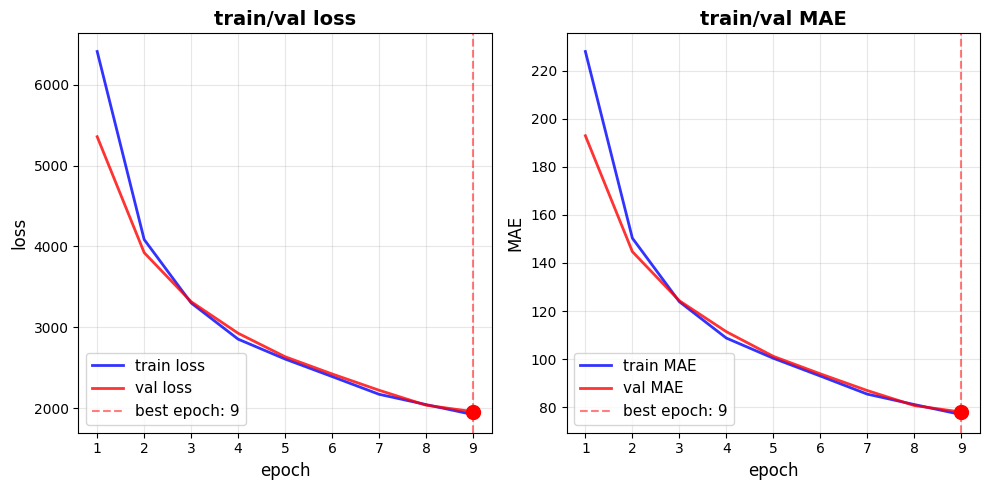


stat:
final train loss: 1919.1
final val loss:   1955.0
final train MAE:  76.9
final val MAE:    78.0

best val loss:  1955.0 (epoch 9)
best val MAE:     78.0 (epoch 9)



  val epoch 10 : 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, last batch loss=1351.8, last batch mae=58.2]


total epoch 10  train loss 1826.6, val loss 1903.8 train mae 73.8, val mae 76.2
----------------------------------------
New best model, epoch: 10
----------------------------------------


  val epoch 11 : 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, last batch loss=1262.1, last batch mae=54.6]


total epoch 11  train loss 1699.8, val loss 1812.4 train mae 69.4, val mae 72.9
----------------------------------------
New best model, epoch: 11
----------------------------------------


  val epoch 12 : 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, last batch loss=1192.6, last batch mae=51.9]


total epoch 12  train loss 1590.9, val loss 1712.8 train mae 65.6, val mae 69.5
----------------------------------------
New best model, epoch: 12
----------------------------------------


  val epoch 13 : 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, last batch loss=1135.8, last batch mae=50.3]


total epoch 13  train loss 1560.3, val loss 1666.5 train mae 64.5, val mae 67.8
----------------------------------------
New best model, epoch: 13
----------------------------------------


  val epoch 14 : 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, last batch loss=1037.8, last batch mae=46.6]


total epoch 14  train loss 1491.6, val loss 1631.1 train mae 62.0, val mae 66.9
----------------------------------------
New best model, epoch: 14
----------------------------------------


  val epoch 15 : 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, last batch loss=1030.3, last batch mae=46.6]


total epoch 15  train loss 1435.5, val loss 1543.7 train mae 60.2, val mae 63.9
----------------------------------------
New best model, epoch: 15
----------------------------------------


  val epoch 16 : 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, last batch loss=968.0, last batch mae=44.1] 


total epoch 16  train loss 1347.3, val loss 1487.8 train mae 57.2, val mae 61.8
----------------------------------------
New best model, epoch: 16
----------------------------------------


  val epoch 17 : 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, last batch loss=948.0, last batch mae=43.2] 


total epoch 17  train loss 1345.1, val loss 1481.8 train mae 57.0, val mae 61.4
----------------------------------------
New best model, epoch: 17
----------------------------------------


  val epoch 18 : 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, last batch loss=873.4, last batch mae=40.7] 


total epoch 18  train loss 1326.7, val loss 1403.9 train mae 56.3, val mae 58.8
----------------------------------------
New best model, epoch: 18
----------------------------------------



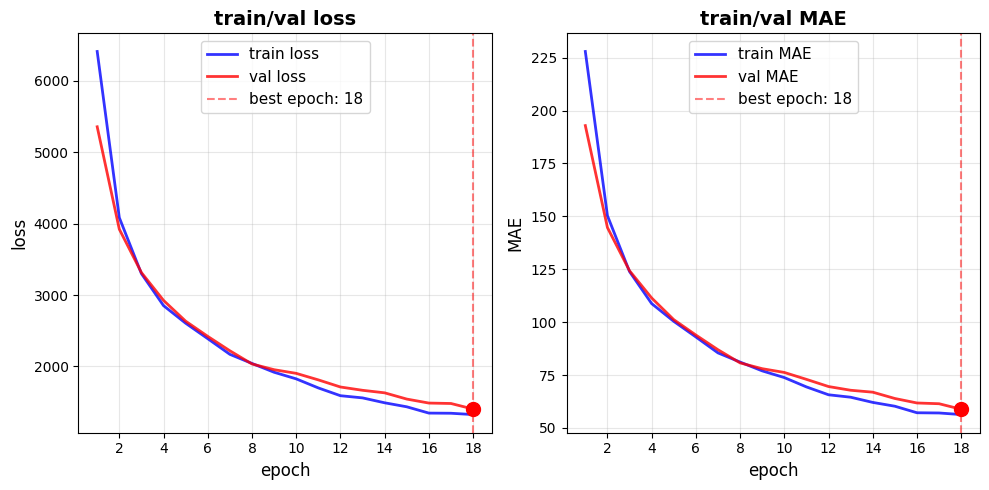


stat:
final train loss: 1326.7
final val loss:   1403.9
final train MAE:  56.3
final val MAE:    58.8

best val loss:  1403.9 (epoch 18)
best val MAE:     58.8 (epoch 18)



  val epoch 19 : 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, last batch loss=887.4, last batch mae=41.7] 


total epoch 19  train loss 1262.1, val loss 1409.5 train mae 54.2, val mae 59.1
----------------------------------------


  val epoch 20 : 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, last batch loss=880.5, last batch mae=41.4] 


total epoch 20  train loss 1262.2, val loss 1409.0 train mae 54.1, val mae 59.1
----------------------------------------


  val epoch 21 : 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, last batch loss=822.7, last batch mae=37.9] 


total epoch 21  train loss 1181.7, val loss 1306.8 train mae 51.3, val mae 55.3
----------------------------------------
New best model, epoch: 21
----------------------------------------


  val epoch 22 : 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, last batch loss=928.1, last batch mae=42.8] 


total epoch 22  train loss 1178.4, val loss 1382.6 train mae 51.3, val mae 58.2
----------------------------------------


  val epoch 23 : 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, last batch loss=843.7, last batch mae=39.6] 


total epoch 23  train loss 1175.0, val loss 1329.0 train mae 51.1, val mae 56.2
----------------------------------------


  val epoch 24 : 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, last batch loss=861.3, last batch mae=40.2] 


total epoch 24  train loss 1170.4, val loss 1301.7 train mae 50.9, val mae 55.2
----------------------------------------
New best model, epoch: 24
----------------------------------------


  val epoch 25 : 100%|██████████| 8/8 [00:07<00:00,  1.11it/s, last batch loss=825.5, last batch mae=38.6] 


total epoch 25  train loss 1165.1, val loss 1308.5 train mae 50.7, val mae 55.4
----------------------------------------


  val epoch 26 : 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, last batch loss=778.0, last batch mae=36.9] 


total epoch 26  train loss 1111.7, val loss 1293.8 train mae 48.9, val mae 54.9
----------------------------------------
New best model, epoch: 26
----------------------------------------


  val epoch 27 : 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, last batch loss=800.5, last batch mae=38.2] 


total epoch 27  train loss 1119.0, val loss 1326.2 train mae 49.2, val mae 56.1
----------------------------------------



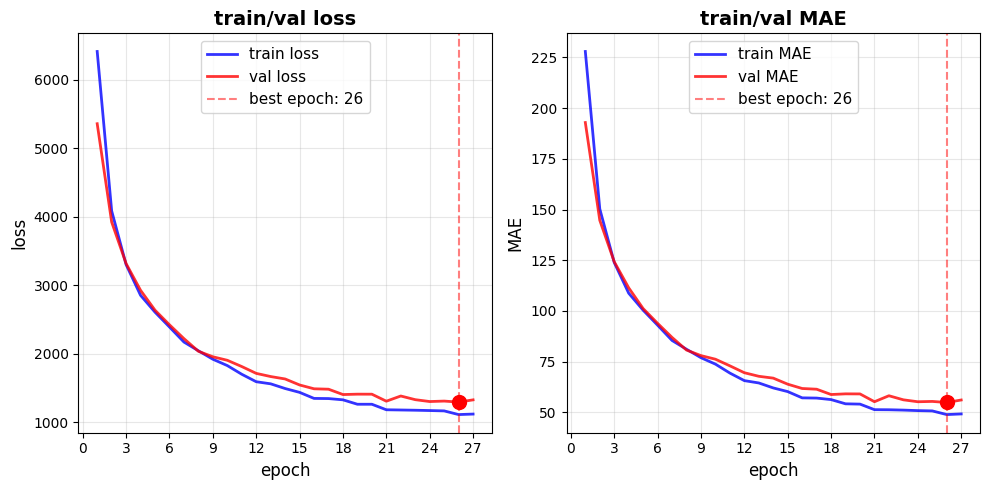


stat:
final train loss: 1119.0
final val loss:   1326.2
final train MAE:  49.2
final val MAE:    56.1

best val loss:  1293.8 (epoch 26)
best val MAE:     54.9 (epoch 26)



  val epoch 28 : 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, last batch loss=768.7, last batch mae=36.9] 


total epoch 28  train loss 1117.2, val loss 1317.8 train mae 49.0, val mae 55.8
----------------------------------------


  val epoch 29 : 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, last batch loss=833.7, last batch mae=39.1] 


total epoch 29  train loss 1081.1, val loss 1257.2 train mae 47.7, val mae 53.7
----------------------------------------
New best model, epoch: 29
----------------------------------------


  val epoch 30 : 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, last batch loss=739.9, last batch mae=35.8] 


total epoch 30  train loss 1049.4, val loss 1222.1 train mae 46.7, val mae 52.6
----------------------------------------
New best model, epoch: 30
----------------------------------------


  val epoch 31 : 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, last batch loss=754.5, last batch mae=35.8] 


total epoch 31  train loss 1074.1, val loss 1221.2 train mae 47.4, val mae 52.3
----------------------------------------
New best model, epoch: 31
----------------------------------------


  val epoch 32 : 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, last batch loss=782.8, last batch mae=37.2] 


total epoch 32  train loss 1056.8, val loss 1286.1 train mae 46.9, val mae 54.6
----------------------------------------


  val epoch 33 : 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, last batch loss=785.9, last batch mae=36.6] 


total epoch 33  train loss 1015.9, val loss 1270.8 train mae 45.6, val mae 53.9
----------------------------------------


  val epoch 34 : 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, last batch loss=818.5, last batch mae=38.7] 


total epoch 34  train loss 1018.2, val loss 1282.0 train mae 45.5, val mae 54.5
----------------------------------------


  val epoch 35 : 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, last batch loss=750.1, last batch mae=36.0] 


total epoch 35  train loss 1023.5, val loss 1275.7 train mae 45.8, val mae 54.3
----------------------------------------


  val epoch 36 : 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, last batch loss=805.4, last batch mae=38.8] 


total epoch 36  train loss 1010.2, val loss 1214.3 train mae 45.2, val mae 52.5
----------------------------------------



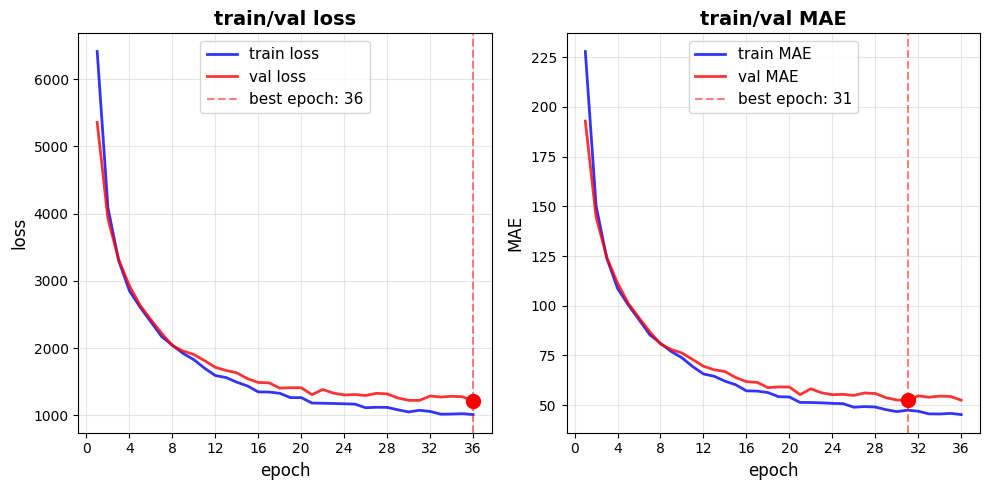


stat:
final train loss: 1010.2
final val loss:   1214.3
final train MAE:  45.2
final val MAE:    52.5

best val loss:  1214.3 (epoch 36)
best val MAE:     52.3 (epoch 31)



  val epoch 37 : 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, last batch loss=801.5, last batch mae=38.0] 


total epoch 37  train loss 1040.5, val loss 1322.8 train mae 46.4, val mae 55.7
----------------------------------------


  val epoch 38 : 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, last batch loss=736.3, last batch mae=35.3] 


total epoch 38  train loss 1014.5, val loss 1240.0 train mae 45.5, val mae 52.9
----------------------------------------


  val epoch 39 : 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, last batch loss=762.6, last batch mae=36.4] 


total epoch 39  train loss 977.9, val loss 1247.3 train mae 44.1, val mae 53.0
----------------------------------------


  val epoch 40 : 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, last batch loss=731.8, last batch mae=35.1] 


total epoch 40  train loss 966.2, val loss 1237.5 train mae 43.6, val mae 52.8
----------------------------------------


  val epoch 41 : 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, last batch loss=741.9, last batch mae=35.6] 


total epoch 41  train loss 984.0, val loss 1253.7 train mae 44.3, val mae 53.7
----------------------------------------


  val epoch 42 : 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, last batch loss=731.8, last batch mae=35.7] 


total epoch 42  train loss 963.1, val loss 1189.0 train mae 43.6, val mae 51.2
----------------------------------------
New best model, epoch: 42
----------------------------------------


  val epoch 43 : 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, last batch loss=754.7, last batch mae=36.6] 


total epoch 43  train loss 975.1, val loss 1204.5 train mae 43.9, val mae 51.6
----------------------------------------


  val epoch 44 : 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, last batch loss=780.7, last batch mae=37.4] 


total epoch 44  train loss 968.5, val loss 1212.0 train mae 43.8, val mae 51.9
----------------------------------------


  val epoch 45 : 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, last batch loss=665.9, last batch mae=33.4] 


total epoch 45  train loss 1014.7, val loss 1128.5 train mae 45.4, val mae 49.0
----------------------------------------
New best model, epoch: 45
----------------------------------------



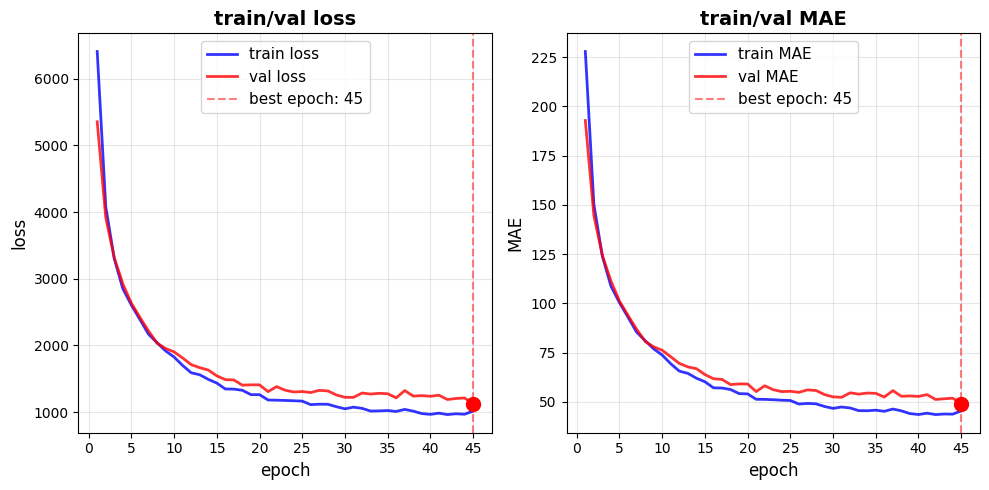


stat:
final train loss: 1014.7
final val loss:   1128.5
final train MAE:  45.4
final val MAE:    49.0

best val loss:  1128.5 (epoch 45)
best val MAE:     49.0 (epoch 45)



In [4]:
train_loss_stat, val_loss_stat, train_mae_stat, val_mae_stat = train(cfg, device)

## Выводы

1. Обучились до требуемой MAE за 45 эпох и ~ 1 мин на эпоху
2. После 10-й эпохи наметилось некоторое переобучение, возможно имело смысл работать c Dropout ближе к 0.5
3. Модель медленно сходится на поздних эпохах, возможно будет уместно применить ReduceOnPlato

# Инференс лучшей модели

val MAE: 49.0


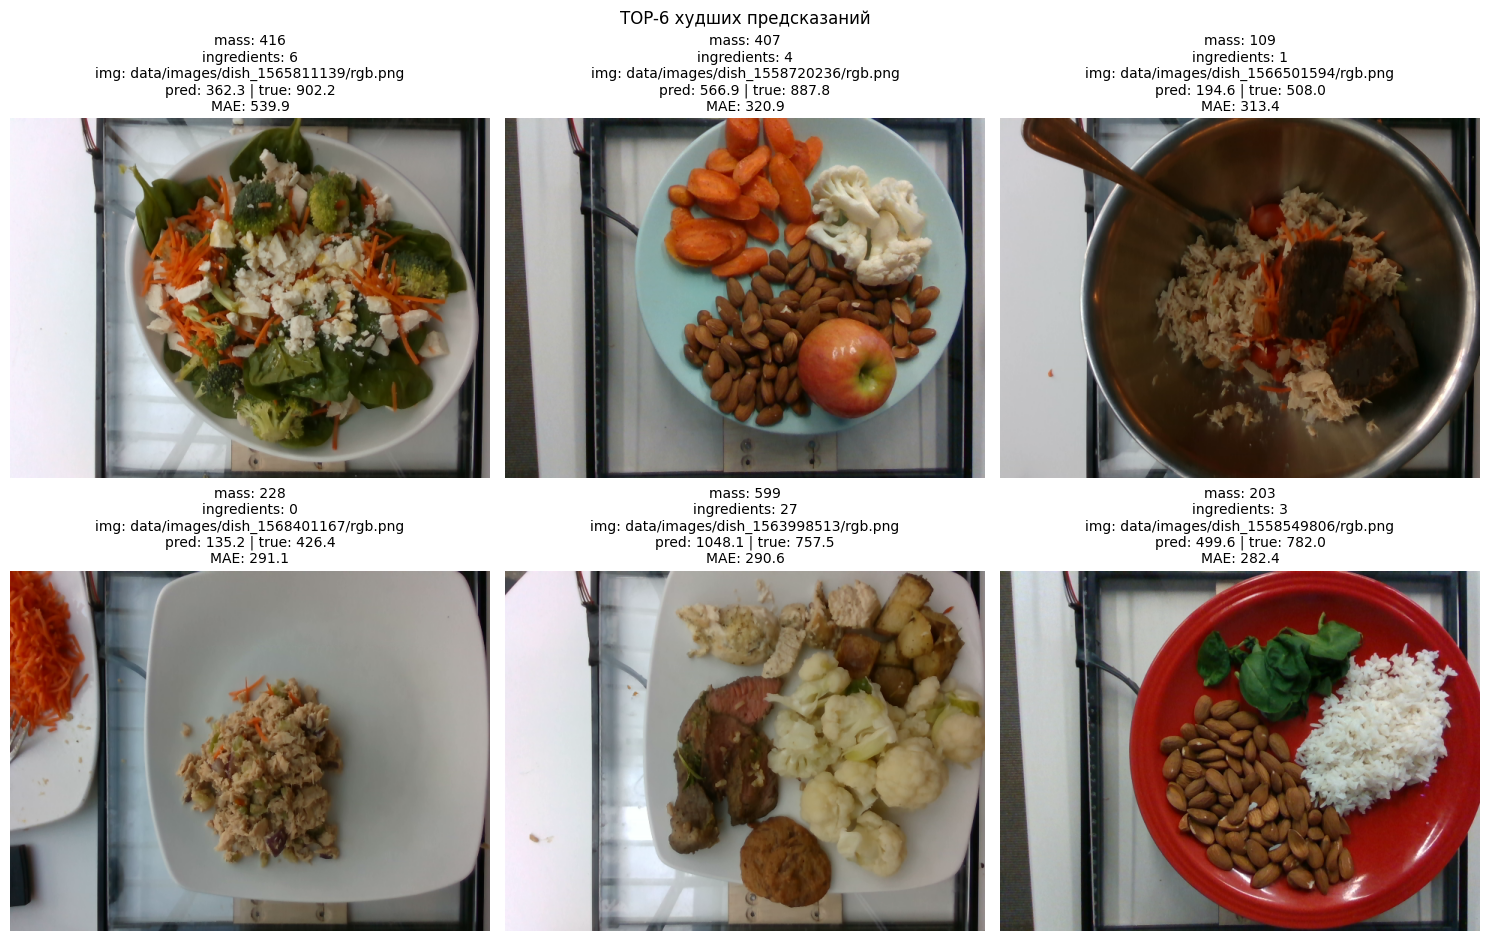

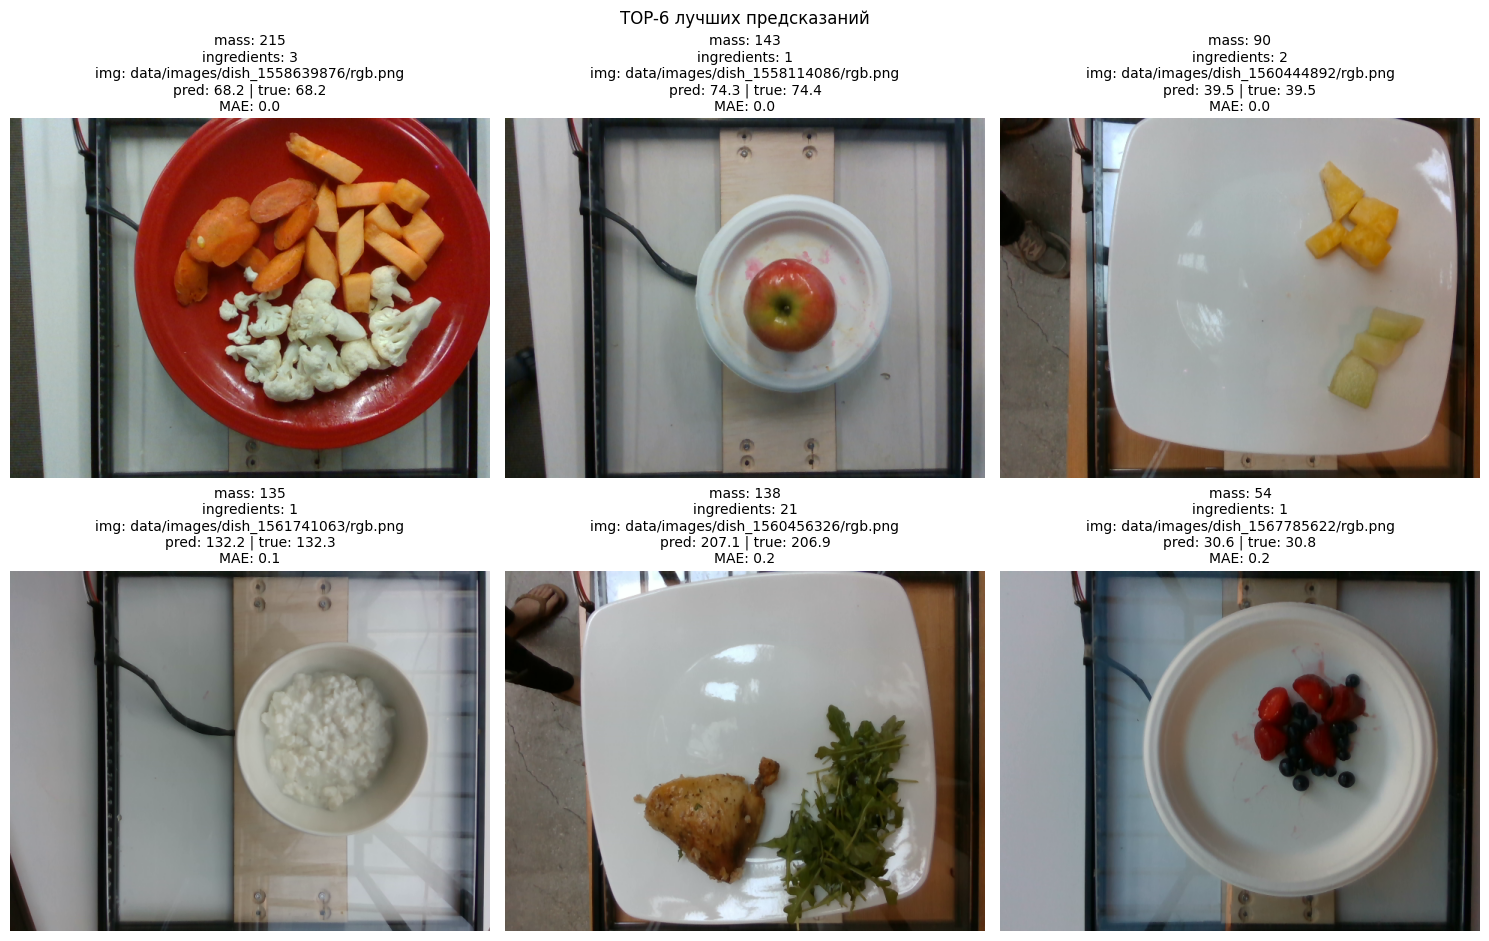

In [3]:
df = check_inference(cfg, device)

## Выводы

**Худшие предсказания**
1. Модель явно не разобралась в высокой калорийности орехов, возможно их было мало в трейне, или она не отличила их от чего то детического.
2. На картинках количество ингредиентов - тех, что встречались в обучающей выборке (как следствие есть блюда с 0 ингридентов). Если модель не получает информации об ингредиентах, они чересчур копозитны и их мало на сложное блюдо (ингредиент - салат из тунца - редкий и сложный), модель ошибается. Можем сделать вывод, что состав - важный для нее признак.
3. Так же среди худших по прдсказаниями - блюда с обилием цветов, видимо модель не смогла их обобщить

**Лучшие предсказания**
1. Модель хорошо сориентировалась с небольшиими по фактическому составу компонентов блюдами
2. Так же, обратим внимание на то, что в топе блюда с хорошо различимыми на картинке деталями

**Предложения по улучшению**
1. Разморозить последние сверточные слои модели, работающей с картинками, - многие мелко нарубленные блюда с виду вряд ли похожи на что-то, что она видела на обучении.
2. Поработать с дисбалансом ингридентов (случай с орехами), возможно - дополнить датасет аугментированными данными с ними.
3. Добавить эпох обучению, предварительно поработав с наметившимся переобучением.